In [1]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from src.model_specpred import SpectrumPredictor
from src.utils_model import lorentzian, spec_to_Sqt, batch_spec_to_Sqt

from matplotlib.colors import to_rgb, to_rgba

from matplotlib.colors import Normalize
from scipy.interpolate import interp1d
import torch
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm

torch.set_default_dtype(torch.float64)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'

/global/homes/z/zhantao/.conda/envs/sqt/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import seaborn
palette_crest = seaborn.color_palette(palette='crest')
palette_flare = seaborn.color_palette(palette='flare')

In [3]:
model_spec = SpectrumPredictor.load_from_checkpoint("production_models/version_large_training_set/checkpoints/epoch=8456-step=422850.ckpt")

In [4]:
data = torch.load("data/CrI3/20221110.pt")
X = data['param'][:,:2]
Y = torch.cat((data['omega'], data['inten']), dim=1)

indices_dict = torch.load("data_splitting/indices_42_800-100-100.pt")
train_indices = indices_dict['train']
val_indices = indices_dict['val']
test_indices = indices_dict['test']

X_train = X[train_indices]
Y_train = Y[train_indices]
train_dataset = TensorDataset(X_train, Y_train)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

X_test = X[test_indices]
Y_test = Y[test_indices]

print("print some values for further reference:")
# print("training:\n", X_train[:5])
# print("validation:\n", X_val[:5])
print("testing:\n", X_test[:5])

print some values for further reference:
testing:
 tensor([[-1.5924e+00, -2.1911e-01],
        [-2.9503e+00, -8.5994e-04],
        [-1.6105e+00, -2.4190e-01],
        [-2.3308e+00, -4.2538e-01],
        [-1.8445e+00, -5.6670e-01]])


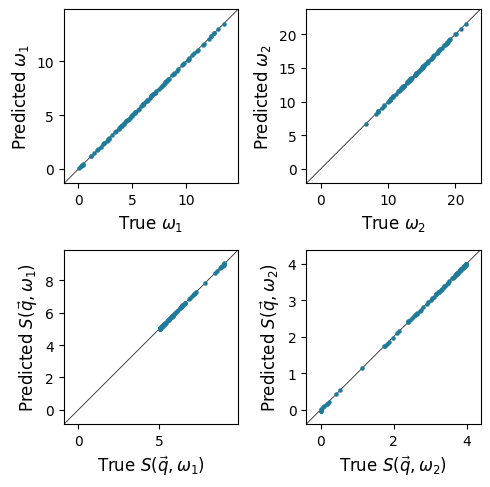

In [5]:
model_spec.to(device)

loss_test = []
Y_test_pred = []
with torch.no_grad():
    for x_test, y_test in zip(X_test, Y_test):
        y_test_pred = model_spec(x_test.to(device)).detach().cpu()
        loss_test.append((y_test_pred - y_test).abs().mean().item())
        Y_test_pred.append(y_test_pred)
Y_test_pred = torch.vstack(Y_test_pred)

labels = [r'$\omega_1$', r'$\omega_2$', r'$S(\vec{q},\omega_{1})$', r'$S(\vec{q},\omega_{2})$']

fig = plt.figure(figsize=(5,5))
gs = plt.GridSpec(2,2)
for i in range(4):
    ax = fig.add_subplot(gs[i])
    ax.plot([-100,100], [-100,100], 'k', linewidth=0.5, zorder=0)
    ax.scatter(Y_test[:,i], Y_test_pred[:,i], s=5, color="#207A9A", zorder=10)
    ax.set_aspect('equal')
    ax.set_xlim([-0.1*Y_test[:,i].max(), 1.1*Y_test[:,i].max()])
    ax.set_ylim([-0.1*Y_test[:,i].max(), 1.1*Y_test[:,i].max()])
    ax.set_xlabel(f"True {labels[i]}", fontsize=12)
    ax.set_ylabel(f"Predicted {labels[i]}", fontsize=12)

fig.tight_layout()
# fig.savefig("figs/paper/network_hist2d.pdf", bbox_inches='tight')

In [6]:
from laplace.baselaplace import FullLaplace, DiagLaplace
from laplace.curvature.backpack import BackPackGGN

from laplace import Laplace, marglik_training

In [7]:
print(model_spec)

SpectrumPredictor(
  (fc_net): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=4, bias=False)
  )
)


In [8]:
la = Laplace(model_spec.fc_net.to(device), 
             'regression', 
             subset_of_weights='all', 
             hessian_structure='kron',)
la.fit(train_dataloader)

In [9]:
log_prior, log_sigma = torch.ones(1, requires_grad=True), torch.ones(1, requires_grad=True)
hyper_optimizer = torch.optim.Adam([log_prior, log_sigma], lr=1e-1)
for i in tqdm(range(1000)):
    hyper_optimizer.zero_grad()
    neg_marglik = - la.log_marginal_likelihood(log_prior.exp(), log_sigma.exp())
    neg_marglik.backward()
    hyper_optimizer.step()

100%|██████████| 1000/1000 [00:01<00:00, 649.22it/s]


In [10]:
def obtain_uncertainty_map():
    J_map, D_map = np.meshgrid(np.linspace(-3,-1,200), np.linspace(-1,0,100))
    X_map = torch.from_numpy(np.concatenate((J_map[...,None], D_map[...,None]), axis=-1).reshape(-1,2))
    map_loader = DataLoader(X_map, batch_size=100, shuffle=False)
    Y_map_mean = []
    Y_map_covar = []
    for _x_map in tqdm(map_loader):
        _Y_map_mean, _Y_map_covar = la(_x_map.to(device))
        Y_map_mean.append(_Y_map_mean.cpu())
        Y_map_covar.append(_Y_map_covar.cpu())
    Y_map_covar = torch.vstack(Y_map_covar)
    return J_map, D_map, Y_map_mean, Y_map_covar
J_map, D_map, Y_map_mean, Y_map_covar = obtain_uncertainty_map()

100%|██████████| 200/200 [00:02<00:00, 82.44it/s]


In [11]:
with torch.no_grad():
    y_test_mean, y_test_covar = la(X_test.to(device))
y_test_covar_trace = torch.einsum("ijj->i", y_test_covar)
ROI_index = torch.where((y_test_covar_trace>0.5) * (y_test_covar_trace<1.5), )[0]
print(ROI_index)

tensor([], device='cuda:0', dtype=torch.int64)


In [12]:
target_idx = 4

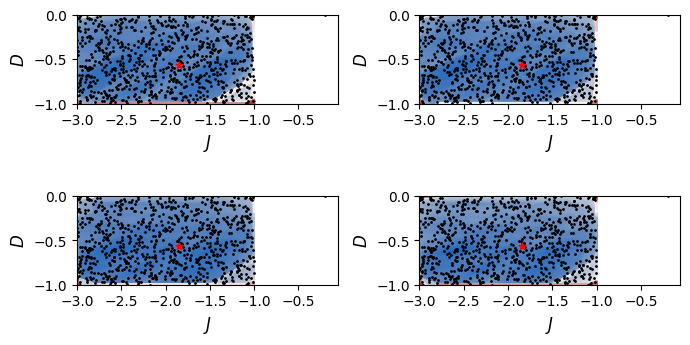

In [13]:
import seaborn as sns
# cmap = matplotlib.colors.Colormap(name, N=256)
cmap = sns.color_palette("vlag", as_cmap=True)

fig = plt.figure(figsize=(7,4))
gs = plt.GridSpec(2,2)
for i in range(4):
    ax = fig.add_subplot(gs[i])
    # ax.plot([-100,100], [-100,100], 'k', linewidth=0.5, zorder=0)
    cnt = ax.contourf(J_map, D_map, Y_map_covar[:,i,i].reshape(J_map.shape).log10(), levels=200, cmap=cmap)
    for c in cnt.collections:
        c.set_edgecolor("face")
    ax.scatter(X_train[:,0], X_train[:,1], c='k', s=1)
    ax.scatter(X_test[target_idx,0], X_test[target_idx,1], c='r', s=25, marker='*')
    # if i == 0:
    #     for j_idx, idx in enumerate(ROI_indices):
    #         ax.scatter(X_test[idx,0], X_test[idx,1], c='r', s=25, marker=rf'${idx}$')
    ax.set_aspect('equal')
    # ax.set_xlim([-0.1*Y_test[:,i].max(), 1.1*Y_test[:,i].max()])
    # ax.set_ylim([-0.1*Y_test[:,i].max(), 1.1*Y_test[:,i].max()])
    ax.set_xlabel(f"$J$", fontsize=12)
    ax.set_ylabel(f"$D$", fontsize=12)

fig.tight_layout()
# fig.savefig("test.pdf")

In [21]:
times = np.arange(0,5,0.01)
settings = (times, )
parameters = (
    np.random.uniform(-3, 0.0, 501),
    np.random.uniform(-1.0,-0.0, 501),
    np.random.uniform( 0.0, 1.0, 501)
    )

In [22]:
%load_ext autoreload
%autoreload 2
from src.bayes import BayesianInference, jit_batch_spec_to_Sqt
from src.utils_model import tensor2array, array2tensor
import optbayesexpt as obe
from src.utils_convolution import get_I_conv, interp_nb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
def prepare_sample(idx, pulse_width=0.1, visualize=False, normalize_to_value=None):
    # prepare Sqt energies and intensities
    x_test = X_test[idx]
    y_test = Y_test[idx]
    gamma = 0.1
    noise_level = 10.0

    omega_test, inten_test = torch.split(y_test, y_test.shape[0]//2)
    true_pars = x_test.cpu().numpy().tolist() + [gamma,]

    # setup time for Sqt computation
    dt = times[1]-times[0]
    times_extended = np.arange(times[0]-pulse_width, times[-1]+pulse_width, dt)
    times_extended_tensor = torch.from_numpy(times_extended)

    # S and |S^2| with NO pulse shape convolution
    true_S = jit_batch_spec_to_Sqt(omega_test, inten_test, times_extended_tensor).sum(dim=1).squeeze() * \
        torch.exp(- gamma * times_extended_tensor)
    true_S = true_S.detach().cpu().numpy()
    # print(true_S.shape)
    if normalize_to_value is not None:
        true_S = np.sqrt(normalize_to_value) * true_S / true_S[int(pulse_width / dt)]
    func_I_noconv = lambda t: interp_nb(t, times_extended, np.abs(true_S)**2)

    # S and |S^2| with pulse shape convolution
    true_I_conv = get_I_conv(times, times_extended, true_S, pulse_width)
    if normalize_to_value is not None:
        true_I_conv = normalize_to_value * true_I_conv / true_I_conv[0]
    func_I_conv = lambda t: interp_nb(t, times, true_I_conv)

    if visualize:
        fig, ax = plt.subplots(1,1)
        ax.plot(times_extended, np.abs(true_S)**2)
        ax.plot(times, true_I_conv)

    return np.asarray(true_pars), func_I_conv, func_I_noconv

def measure_function(sets, pars, cons, func):
    """ Evaluates a trusted model of the experiment's output
    The equivalent of a fit function. The argument structure is
    required by OptBayesExpt.
    Args:
        sets: A tuple of setting values, or a tuple of settings arrays
        pars: A tuple of parameter arrays or a tuple of parameter values
        cons: A tuple of floats
    Returns:  the evaluated function
    """
    # unpack the settings
    # t, = sets
    # unpack model parameters
    t, = sets
    if isinstance(t, (int, float)):
        t = np.array([t,])
    else:
        t = np.atleast_1d(tensor2array(t))
    I_pred = func(t)
    return I_pred

In [24]:
pulse_width = 0.2
noise_level = 10.0
N_steps_bayes = 200
normalize_to_value = 100

In [25]:
param_true, func_I_conv, func_I_noconv = prepare_sample(target_idx, pulse_width=pulse_width, normalize_to_value=normalize_to_value)
print(param_true)
obe_sim = obe.MeasurementSimulator(
    lambda s, p, c: measure_function(s, p, c, func_I_conv), param_true, (), noise_level=noise_level)
obe_sim_noisefree = obe.MeasurementSimulator(
    lambda s, p, c: measure_function(s, p, c, func_I_conv), param_true, (), noise_level=0)

[-1.84452225 -0.56670102  0.1       ]


In [26]:
bayes = BayesianInference(
    la.model, settings, parameters,
    pulse_width=pulse_width, reference_setting_value=((0,), normalize_to_value),
    model_uncertainty=False, device=device)
# bayes.obe_model.set_selection_method('sequential')
particles_hist, p_weights_hist, errors = bayes.run_N_steps_OptBayesExpt_w_GD(
    N_steps_bayes, obe_sim, N_GD=200, lr=1e-4, ret_particles=True, verbose=True, gd_seperation=50, error_criterion=50)
# particles_hist, p_weights_hist = bayes.run_N_steps_OptBayesExpt(
#     100, obe_sim, ret_particles=True, verbose=True)
print(bayes.obe_model.mean(), bayes.obe_model.std())

using the optimal setting


Running OptBayesExpt:  25%|██▌       | 50/200 [00:05<00:15,  9.39it/s]

running GD at step 50, current error 85.47011378884932


Running OptBayesExpt:  50%|█████     | 100/200 [00:11<00:11,  8.64it/s]

running GD at step 100, current error 104.06548537017673


Running OptBayesExpt:  75%|███████▌  | 150/200 [00:18<00:06,  7.94it/s]

running GD at step 150, current error 116.34137319471343


Running OptBayesExpt: 100%|██████████| 200/200 [00:24<00:00,  8.02it/s]

[-1.84155466 -0.57128134  0.13631576] [0.00406154 0.00111404 0.0049024 ]


In [27]:
bayes.get_all_measurements()[0]

array([[0.25],
       [0.45],
       [3.03],
       [2.25],
       [1.55],
       [0.79],
       [2.83],
       [2.17],
       [1.86],
       [2.95],
       [1.22],
       [2.37],
       [3.32],
       [1.98],
       [2.64],
       [3.72],
       [3.26],
       [4.96],
       [3.08],
       [4.05],
       [4.49],
       [2.6 ],
       [2.42],
       [1.64],
       [3.79],
       [3.67],
       [4.66],
       [2.81],
       [4.99],
       [2.18],
       [3.24],
       [4.22],
       [2.61],
       [1.74],
       [4.22],
       [2.38],
       [2.08],
       [3.59],
       [2.85],
       [4.92],
       [1.42],
       [4.12],
       [3.49],
       [3.05],
       [2.81],
       [4.48],
       [4.66],
       [1.95],
       [2.18],
       [3.33],
       [2.61],
       [0.38],
       [0.7 ],
       [0.99],
       [0.57],
       [0.39],
       [0.9 ],
       [0.21],
       [2.71],
       [1.57],
       [1.46],
       [2.51],
       [1.31],
       [4.83],
       [3.13],
       [4.71],
       [2.

In [ ]:
param_mean = np.asarray(bayes.param_mean)
param_std = np.asarray(bayes.param_std)

idx_plot = 50
utility_plot = bayes.utility_list[idx_plot]
utility_plot = 20 * utility_plot / utility_plot.max()

measured_settings, measured_observables = bayes.get_all_measurements()
_, measurements_noisefree = bayes.measure_all_settings(obe_sim_noisefree)
_, measurements_predicted = bayes.predict_all_settings(param_mean[idx_plot-1])
measurements_predicted *= normalize_to_value / measurements_predicted[0]


In [ ]:
maxiter = len(param_mean)

colors = [palette_crest[0], palette_crest[-3], palette_flare[0]]

label_lst = ["$J$", "$D$", "$\gamma$"]
fig, ax = plt.subplots(1,1,figsize=(5,3))

ax.plot(times.squeeze(), measurements_noisefree, 'k--', label="Ground Truth", zorder=5, linewidth=1)
# # ax[1].plot(time_val, model_function((time_val,), obe_model.mean(), ()), 'r--', label="Ground Truth")
ax.plot(times.squeeze(), measurements_predicted, color=palette_flare[0], label="Model Prediction", zorder=5)
ax.fill_between(times.squeeze(), measurements_predicted-utility_plot, measurements_predicted+utility_plot, color=palette_flare[0], zorder=1, alpha=0.25)
ax.scatter(measured_settings.squeeze()[:idx_plot], measured_observables.squeeze()[:idx_plot], label="Measured", s=30, color=palette_crest[-3], zorder=10)
ax.scatter(measured_settings.squeeze()[idx_plot], measured_observables.squeeze()[idx_plot], label="Proposed", s=50, color=palette_flare[-1], zorder=20, marker='^')
ax.legend(fontsize=10)
ax.set_xlabel('$t$', fontsize=15)
ax.set_ylim([-15, measurements_noisefree.max()+15])
ax.set_ylabel(r'$\left|\bar{S}(q,t)\right|^{2}$', fontsize=15)
ax.set_title(f"Iteration {idx_plot}", fontsize=15)

fig.tight_layout()
# fig.savefig(f'figs/paper/exp_steering_sqt_sample{idx}_iter{idx_plot}.pdf')

In [ ]:
maxiter = len(param_mean)

colors = [palette_crest[0], palette_crest[-3], palette_flare[0]]

label_lst = ["$J$", "$D$", "$\gamma$"]
fig, ax = plt.subplots(1,1,figsize=(5,3))
for i in range(param_mean.shape[1]):
    ax.fill_between(np.arange(maxiter), param_mean[:,i]-param_std[:,i], param_mean[:,i]+param_std[:,i], color=colors[i], alpha=0.2)
    ax.hlines(param_true[i], -100, 100*maxiter, linestyles='--', color='gray')
    ax.plot(np.arange(maxiter), param_mean[:,i], color=colors[i], label=label_lst[i])
ax.set_xlim([-0.*maxiter, 1.2*maxiter])
ax.legend(loc='best', fontsize=10)
ax.set_xlabel("Iterations", fontsize=15)
ax.set_ylabel("Parameters", fontsize=15)

fig.tight_layout()
# fig.savefig(f'figs/paper/exp_steering_paramhist_sample{idx}.pdf')

In [ ]:
plt.plot(errors)

In [ ]:
maxiter = len(param_mean)

colors = [palette_crest[0], palette_crest[-3], palette_flare[0]]

label_lst = ["$J$", "$D$", "$\gamma$"]
fig, ax = plt.subplots(2,1,figsize=(6,6))
for i in range(param_mean.shape[1]):
    ax[0].fill_between(np.arange(maxiter)[:idx_plot-1], param_mean[:idx_plot-1,i]-param_std[:idx_plot-1,i], param_mean[:idx_plot-1,i]+param_std[:idx_plot-1,i], color=colors[i], alpha=0.2)
    ax[0].hlines(true_pars[i], -100, 100*maxiter, linestyles='--', color='gray')
    ax[0].plot(np.arange(maxiter)[:idx_plot-1], param_mean[:idx_plot-1,i], color=colors[i], label=label_lst[i])
ax[0].set_xlim([-0.*idx_plot, 1.2*idx_plot])
ax[0].legend(fontsize=10)
ax[0].set_xlabel("Iterations", fontsize=15)
ax[0].set_ylabel("Parameters", fontsize=15)

ax[1].plot(times.squeeze(), measurements_noisefree, 'k--', label="Ground Truth", zorder=5, linewidth=1)
# # ax[1].plot(time_val, model_function((time_val,), obe_model.mean(), ()), 'r--', label="Ground Truth")
ax[1].plot(times.squeeze(), measurements_predicted, color=palette_flare[0], label="Model Prediction", zorder=5)
ax[1].fill_between(times.squeeze(), measurements_predicted-utility_plot, measurements_predicted+utility_plot, color=palette_flare[0], zorder=1, alpha=0.25)
ax[1].scatter(measured_settings.squeeze()[:idx_plot], measured_observables.squeeze()[:idx_plot], label="Measured", s=30, color=palette_crest[-3], zorder=10)
ax[1].scatter(measured_settings.squeeze()[idx_plot], measured_observables.squeeze()[idx_plot], label="Proposed", s=50, color=palette_flare[-1], zorder=20, marker='^')
ax[1].legend(fontsize=10)
ax[1].set_xlabel('$t$', fontsize=15)
ax[1].set_ylabel(r'$\left|\bar{S}(q,t)\right|^{2}$', fontsize=15)

fig.tight_layout()
fig.savefig(f'figs/paper/exp_steering_sample{idx}_iter{idx_plot}.pdf')

In [ ]:
plt.plot(bayes.obe_model.cost_estimate())
# plt.plot(bayes.utility_list[-1])

In [ ]:
gd_loss_hist, gd_param_hist = bayes.run_gradient_desc_on_current_measurements(
    200, lr=0.001, batch_size=bayes.obe_model.n_particles, init_bayes_guess=False)

In [ ]:
def normalize(arr, arr_min, arr_max):
    delta_arr = (arr.max() - arr.min())
    if delta_arr > 0:
        arr_new = (arr - arr.min()) / delta_arr
        arr_new = arr_new * (arr_max - arr_min) + arr_min
        return arr_new
    else:
        return np.ones_like(arr)

In [ ]:
cmap = seaborn.color_palette(palette='flare', as_cmap=True)
norm = Normalize(0, len(particles_hist)-1)

In [ ]:
def plot_scatter_series(data, special_point=None, labels=None, special_point_label=None, save_name=None):
    data_size, num_points = data.shape[0], data.shape[-1]
    norm = Normalize(0, data_size-1)
    fig, ax = plt.subplots(1,1,figsize=(5,5))
    if labels is not None:
        assert len(labels) == data_size
    
    for i in range(data_size):
        colors = np.array(cmap(norm(i)))[np.newaxis,:].repeat(num_points, axis=0)
        # colors[:,-1] = normalize(p_weights_hist[i], 0.25, 0.5)
        # colors[:,-1] = 0.25
        ax.scatter(data[i,0], data[i,1], color=colors, s=10, label=None if labels is None else labels[i])
    if special_point is not None:
        ax.scatter(special_point[0], special_point[1], color="#70B6A1", marker='*', s=30)
    if labels is not None:
        ax.legend(ncol = 2, fontsize=10)
    ax.set_xlabel("$J$", fontsize=15)
    ax.set_ylabel("$D$", fontsize=15)
    if save_name is not None:
        fig.savefig(save_name, dpi=300, bbox_inches='tight')

In [ ]:
# indices = np.linspace(0, len(particles_hist)-1, 5).astype('int')
indices = [0, 5, 6, 49]
plot_scatter_series(particles_hist[indices], labels=[f'Iteration {i}' for i in indices], save_name=f'figs/paper/baysian_population_evolution_sample{idx}.pdf')

In [ ]:
gd_param_hist_for_plot = torch.cat((gd_param_hist['J'][:,None], gd_param_hist['D'][:,None]), dim=1).numpy()
indices = np.linspace(0, len(gd_param_hist_for_plot)-1, 5).astype('int')
plot_scatter_series(gd_param_hist_for_plot[indices], save_name='figs/paper/gd_first_round.pdf')

In [ ]:
ranges_J = [bayes.forward_model.J.min().item()-0.25, bayes.forward_model.J.max().item()+0.25]
ranges_D = [bayes.forward_model.D.min().item()-0.25, bayes.forward_model.D.max().item()+0.25]

fig, ax = plt.subplots(1,1)
ax.hist2d(
    bayes.forward_model.J.squeeze().detach().cpu().numpy(), 
    bayes.forward_model.D.squeeze().detach().cpu().numpy(), 
    bins=[int((ranges_J[1]-ranges_J[0])//0.05),int((ranges_D[1]-ranges_D[0])//0.05)], range=[ranges_J, ranges_D],
    cmap=plt.colormaps['bone']
)
ax.vlines(x_val[0], -10, 10, colors='white', linestyle='--')
ax.hlines(x_val[1], -10, 10, colors='white', linestyle='--')
ax.set_xlim(ranges_J)
ax.set_xlabel("$J$", fontsize=18)
ax.set_ylim(ranges_D)
ax.set_ylabel("$D$", fontsize=18)
ax.set_aspect('equal')
fig.tight_layout()

In [ ]:
bayes.update_OptBayesExpt_particles()
print(bayes.obe_model.mean(), bayes.obe_model.std())
particles_hist, p_weights_hist = bayes.run_N_steps_OptBayesExpt(50, obe_sim, ret_particles=True)
print(bayes.obe_model.mean(), bayes.obe_model.std())

In [ ]:
indices = np.linspace(0, len(particles_hist)-1, 10).astype('int')
plot_scatter_series(particles_hist[indices], special_point=x_val,save_name='figs/paper/baysian_second_round.pdf')

In [ ]:
_, _ = bayes.run_gradient_desc_on_current_measurements(100, batch_size=bayes.obe_model.n_particles, init_bayes_guess=False)

In [ ]:
ranges_J = [bayes.forward_model.J.min().item()-0.25, bayes.forward_model.J.max().item()+0.25]
ranges_D = [bayes.forward_model.D.min().item()-0.25, bayes.forward_model.D.max().item()+0.25]

fig, ax = plt.subplots(1,1)
ax.hist2d(
    bayes.forward_model.J.squeeze().detach().cpu().numpy(), 
    bayes.forward_model.D.squeeze().detach().cpu().numpy(), 
    bins=[int((ranges_J[1]-ranges_J[0])//0.05),int((ranges_D[1]-ranges_D[0])//0.05)], range=[ranges_J, ranges_D],
    cmap=plt.colormaps['bone']
)
ax.vlines(x_val[0], -10, 10, colors='white', linestyle='--')
ax.hlines(x_val[1], -10, 10, colors='white', linestyle='--')
ax.set_xlim(ranges_J)
ax.set_xlabel("$J$", fontsize=18)
ax.set_ylim(ranges_D)
ax.set_ylabel("$D$", fontsize=18)
ax.set_aspect('equal')
fig.tight_layout()

In [ ]:
param_mean = np.asarray(bayes.param_mean)
param_std = np.asarray(bayes.param_std)

measured_settings, measured_observables = bayes.get_all_measurements()
_, measurements_noisefree = bayes.measure_all_settings(obe_sim_noisefree)
_, measurements_predicted = bayes.predict_all_settings()

In [ ]:
maxiter = len(param_mean)

colors = [palette_crest[0], palette_crest[-3], palette_flare[0]]

label_lst = ["$J$", "$D$", "$\gamma$"]
fig, ax = plt.subplots(2,1,figsize=(6,6))
for i in range(param_mean.shape[1]):
    ax[0].fill_between(np.arange(maxiter), param_mean[:,i]-param_std[:,i], param_mean[:,i]+param_std[:,i], color=colors[i], alpha=0.2)
    ax[0].hlines(true_pars[i], -100, 100*maxiter, linestyles='--', color='gray')
    ax[0].plot(np.arange(maxiter), param_mean[:,i], color=colors[i], label=label_lst[i])
ax[0].set_xlim([-0.*maxiter, 1.2*maxiter])
ax[0].legend()
ax[0].set_xlabel("Iterations", fontsize=12)
ax[0].set_ylabel("Parameters", fontsize=12)

ax[1].plot(times.squeeze(), measurements_noisefree, 'k--', label="Ground Truth", zorder=5, linewidth=1)
# # ax[1].plot(time_val, model_function((time_val,), obe_model.mean(), ()), 'r--', label="Ground Truth")
ax[1].plot(times.squeeze(), measurements_predicted, color=palette_flare[0], label="Model Prediction", zorder=1)
ax[1].scatter(measured_settings.squeeze(), measured_observables.squeeze(), label="Measurement", s=12, color=palette_crest[-3], zorder=10)
ax[1].legend(fontsize=9)
ax[1].set_xlabel('$t$', fontsize=12)
ax[1].set_ylabel(r'$\left|\bar{S}(q,t)\right|^{2}$', fontsize=12)

fig.tight_layout()
fig.savefig('figs/paper/exp_steering.pdf')

In [ ]:
from matplotlib.animation import FuncAnimation

fig = plt.Figure(figsize=(6,6)) # this creates a Figure() instance
# ax = fig.add_subplot()
gs = fig.add_gridspec(2,1)
ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1])

ax0.set_xlim([-0.*maxiter, 1.2*maxiter])
ax0.set_ylim([-3.1,1.0])
ax0.set_xlabel("Iterations", fontsize=18)
ax0.set_ylabel("Parameters", fontsize=18)
for i in range(param_mean.shape[1]):
    # ax[0].fill_between(np.arange(maxiter), param_mean[:,i]-param_std[:,i], param_mean[:,i]+param_std[:,i], alpha=0.2)
    ax0.hlines(true_pars[i], -100, 100*maxiter, linestyles='--', color='gray')

ax1.set_xlim([0, 1.1*times.max()])
ax1.plot(times, true_S, color='k', label="Ground Truth")
ax1.set_xlabel("$t$", fontsize=18)
ax1.set_ylabel("$S(q,t)$", fontsize=18)
line_pred, = ax1.plot([], [], lw=2)
sc = ax1.scatter([], [], color='C2', s=12)

line_J, = ax0.plot([], [], lw=2)
line_D, = ax0.plot([], [], lw=2)
line_gamma, = ax0.plot([], [], lw=2)
fig.tight_layout()

def init():
    i=1
    line_J.set_data(np.arange(i), param_mean[:i,0])
    line_D.set_data(np.arange(i), param_mean[:i,1])
    line_gamma.set_data(np.arange(i), param_mean[:i,2])
    line_J.set_label(label_lst[0])
    line_D.set_label(label_lst[1])
    line_gamma.set_label(label_lst[2])
    ax0.legend(loc='center right')
    sc.set_offsets(np.concatenate((measured_settings.squeeze()[:i,None], measured_observables.squeeze()[:i,None]),axis=1))
    line_pred.set_data(times, bayes.model_predictions_on_obe_mean[i])
    sc.set_zorder(10)
    return line_J, line_D, line_gamma, sc, line_pred
def animate(i):
    line_J.set_data(np.arange(i), param_mean[:i,0])
    line_D.set_data(np.arange(i), param_mean[:i,1])
    line_gamma.set_data(np.arange(i), param_mean[:i,2])
    sc.set_offsets(np.concatenate((measured_settings.squeeze()[:i,None], measured_observables.squeeze()[:i,None]),axis=1))
    line_pred.set_data(times, bayes.model_predictions_on_obe_mean[i])
    sc.set_zorder(10)
    return line_J, line_D, line_gamma, sc, line_pred

anim = FuncAnimation(
    fig, animate, init_func=init,
    frames=maxiter, interval=100, blit=True)

anim.save(f'out/gifs/sequential_J={true_pars[0]:.3f}_D={true_pars[1]:.3f}_gamma={true_pars[2]:.3f}.gif', dpi=300)